<a target="_blank" href="https://colab.research.google.com/github.com/giordamaug/HELP/blob/v2.0/notebooks/prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/v2.0/notebooks/prediction.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP and ICARlearn from GitHub
Skip this cell if you already have installed HELP and the ICARlearn library.

In [ ]:
!pip install git+https://github.com/giordamaug/HELP.git
!pip install git+https://github.com/giordamaug/ICARlearn.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from Zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.12620877.svg)](https://doi.org/10.5281/zenodo.12620877)
 the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [23]:
from HELPpy.utility.utils import pdread_csv_fromurl
tissue='Kidney'
X_bio = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_BIO.csv", index_col=0)
X_n2v = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_EmbN2V_128.csv", index_col=0)
X_cccfs = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_CCcfs.csv", index_col=0)
Y = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_HELP.csv", index_col=0)

### 3. Pre-processing and merge input files
We apply pre-processing only to the BIO and CCcfs attributes.
+ constant attributes removal, and
+ data scaling with z-score.  

We also replace `E` label (positive label) and `aE` and `sNE` labels as 0 label (negative label), to address binary `E vs NE` classification.

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df_y = Y.replace({'aE': 0, 'sNE': 0, 'E': 1})              # rename labels to set binary classification E=1, NE=0
print(df_y.value_counts(normalize=False))
def preproc(df):
    consts = df.columns[df.nunique() <= 1].values
    print(f"Removing {len(consts)} constant features ...")
    df = df.drop(consts, axis=1)
    df = pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)
    return df
X_bio = preproc(X_bio)
X_cccfs = preproc(X_cccfs)
df_X = pd.merge(X_bio, X_n2v, left_index=True, right_index=True, how='outer')
df_X = pd.merge(df_X, X_cccfs, left_index=True, right_index=True, how='outer')
idxs = np.intersect1d(df_y.index.values, df_X.index.values)
df_X = df_X.loc[idxs]
df_y = df_y.loc[idxs]
dataset = pd.concat([df_X, df_y], axis=1)

label
0        16678
1         1253
Name: count, dtype: int64
Removing 0 constant features ...
Removing 3 constant features ...


### 4. Estimate the performance of EGs prediction 

First we define the metrics we want to measure for perfromance analysis.

In [25]:
from imblearn.metrics import specificity_score
from sklearn.metrics import *
myscorer = { 'ROC-AUC':      (roc_auc_score, {'multi_class':'ovr', 'average':'macro'}),
             'Accuracy'  :   (accuracy_score , {}),
             'BA'  :         (balanced_accuracy_score , {}),
             'Sensitivity' : (recall_score   , {'pos_label': 1}),
             'Specificity' : (specificity_score, {'pos_label': 1}),
             'MCC' :         (matthews_corrcoef, {}), 
            }

The, we instantiate the prediction model developed by CDS group if ICAR-CNR ([ICARlearn](https://github.com/giordamaug/ICARlearn)), i.e. the splitting voting ensemble of LightGBM `SplitVotingEnsembleLGBM` with `n_voters=13` classifiers) and estimate its performance via 5-fold cross-validation (`skfold_cv` with `n_splits=5`). Then, print the obtained average performances (`df_scores`)... 

LGBMClassifier(n_estimators=200, random_state=42, verbose=-1)
Classification with sveLGBM...


5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

,measure
ROC-AUC,0.950±0.008
Accuracy,0.856±0.005
BA,0.876±0.012
Specificity,0.852±0.006
Sensitivity,0.900±0.027
MCC,0.485±0.013
cm,"[[13633, 2361], [124, 1118]]"


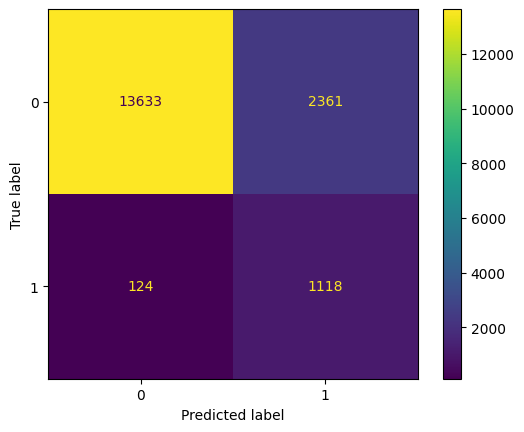

In [6]:
from icarlearn.ensemble.splitvotingens import sveLGBM
from icarlearn.validation.crossvalidate import skfold_cv
clf = sveLGBM(learning_rate=0.1, n_estimators=200, boosting_type='gbdt', n_jobs=-1, random_state=42)
df_scores, scores, predictions = skfold_cv(df_X, df_y, clf, n_splits=5, seed=0, scorer=myscorer, show_progress=True, verbose=True)
df_scores

### 5. Iterating EG predictions and collecting distributions of metrics
The cross-validation step for EG prediction can be iterated 10 times (`n_repeat=10`). At the end of the iteration loop the performance metrics means and standard deviations are calculated. 

In [27]:
from joblib import Parallel, delayed
from icarlearn.validation.crossvalidate import skfold_cv
import os
scores = pd.DataFrame()
preds = pd.DataFrame()
n_folds = 5
n_repeats = 10
n_jobs = -1        # all cpus
verbose = True
clf = sveLGBM(n_voters=13, learning_rate=0.1, n_estimators=200, boosting_type='gbdt', n_jobs=-1, random_state=42)
out = Parallel(n_jobs=n_jobs)(delayed(skfold_cv)(df_X, df_y, clf, n_splits=n_folds, seed=rseed, 
                                               show_progress=True, verbose=verbose, scorer=myscorer) for rseed in range(n_repeats))
for iter,res in enumerate(out):
   scores = pd.concat([scores,res[1]])
   preds = pd.concat([preds,res[2]])
df_scores = pd.DataFrame([f'{val:.4f}±{err:.4f}' for val, err in zip(scores.loc[:, scores.columns != "cm"].mean(axis=0).values,
                          scores.loc[:, scores.columns != "cm"].std(axis=0))] + [(scores[['cm']].sum()/n_repeats).values[0].tolist()],
                          columns=['measure'], index=scores.columns)
display(df_scores)

LGBMClassifier(n_estimators=200, random_state=42, verbose=-1)
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...
Classification with sveLGBM...


5-fold:  60%|██████    | 3/5 [23:50<16:15, 487.91s/it]

#### Display prediction results of last iteration

In [ ]:
display(preds)